In [29]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

In [30]:
df = pd.read_csv('Final_cleaned_data.csv')

In [31]:
df.head()

,ISBN,Publisher,Book_Title,Book_Author,First_Publish_Year,Edition_Count,Book_Age,Edition_Count_Category,Total_Reviews,No_of_Pages,Book_Length_Category,Popularity_Score,Book_Price,Bestseller
0,1881320189,River City Pub,Goodbye to the Buttermilk Sky,Julia Oliver,1994,1,33,Low,189,363,Medium,113.8,32.15,1
1,0440295734,Bantam Books,The Testament,John Grisham,1999,62,26,High,588,474,Medium,377.6,37.70,1
2,0553502271,Random House Audio,The Testament,John Grisham,1999,61,26,High,8,116,Short,29.2,5.80,0
3,0439095026,Scholastic,Tell Me This Isn't Happening,Robynn Clairday,1999,1,26,Low,165,440,Medium,99.4,32.00,1
4,0060168013,Harpercollins,Pigs in Heaven,Barbara Kingsolver,1993,13,32,Medium,88,451,Medium,58.0,38.55,1


In [32]:
labels = df["Bestseller"]

In [33]:
quantitative_cols = [ "Edition_Count", "Book_Age","Total_Reviews","No_of_Pages","Book_Price"]
df_quantitative = df[quantitative_cols]
df_quantitative.to_csv('original_mixed_labeled_data.csv', index=False)

In [34]:
scaler = StandardScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df_quantitative), columns=quantitative_cols)

In [35]:
pca = PCA(n_components=3)
df_pca = pd.DataFrame(pca.fit_transform(df_normalized), columns=["PC1", "PC2", "PC3"])

In [36]:
explained_variance = pca.explained_variance_ratio_.sum()

In [38]:
print("Explained Variance after PCA (3D):", explained_variance)
print("\nOriginal Quantitative Data (Before Normalization):")
print(df_quantitative.head())

print("\nNormalized Data:")
print(df_normalized.head())

print("\nPCA Reduced Data (3D):")
print(df_pca.head())

Explained Variance after PCA (3D): 0.8348018324415644

Original Quantitative Data (Before Normalization):
   Edition_Count  Book_Age  Total_Reviews  No_of_Pages  Book_Price
0              1        33            189          363       32.15
1             62        26            588          474       37.70
2             61        26              8          116        5.80
3              1        26            165          440       32.00
4             13        32             88          451       38.55

Normalized Data:
   Edition_Count  Book_Age  Total_Reviews  No_of_Pages  Book_Price
0      -0.541913  0.522196      -0.780446    -0.796531   -0.729043
1       2.590821 -0.428635       0.929033    -0.362116   -0.328395
2       2.539465 -0.428635      -1.555923    -1.763203   -2.631221
3      -0.541913 -0.428635      -0.883271    -0.495180   -0.739872
4       0.074362  0.386363      -1.213171    -0.452130   -0.267035

PCA Reduced Data (3D):
        PC1       PC2       PC3
0  1.218085  0.0

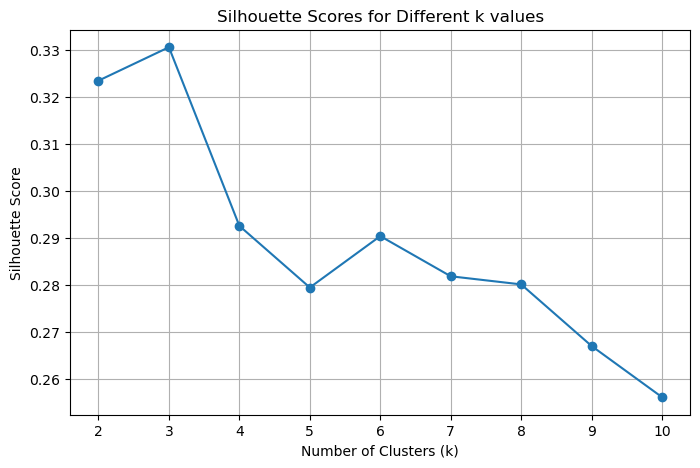

Best k values: [3, 2, 4]


In [21]:
silhouette_scores = []
k_values = list(range(2, 11))  # Testing k from 2 to 10

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_kmeans = kmeans.fit_predict(df_pca)
    score = silhouette_score(df_pca, labels_kmeans)
    silhouette_scores.append(score)

top_k_values = sorted(zip(k_values, silhouette_scores), key=lambda x: x[1], reverse=True)[:3]
best_k_values = [k[0] for k in top_k_values]

plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker="o", linestyle="-")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for Different k values")
plt.grid(True)
plt.show()

print("Best k values:", best_k_values)

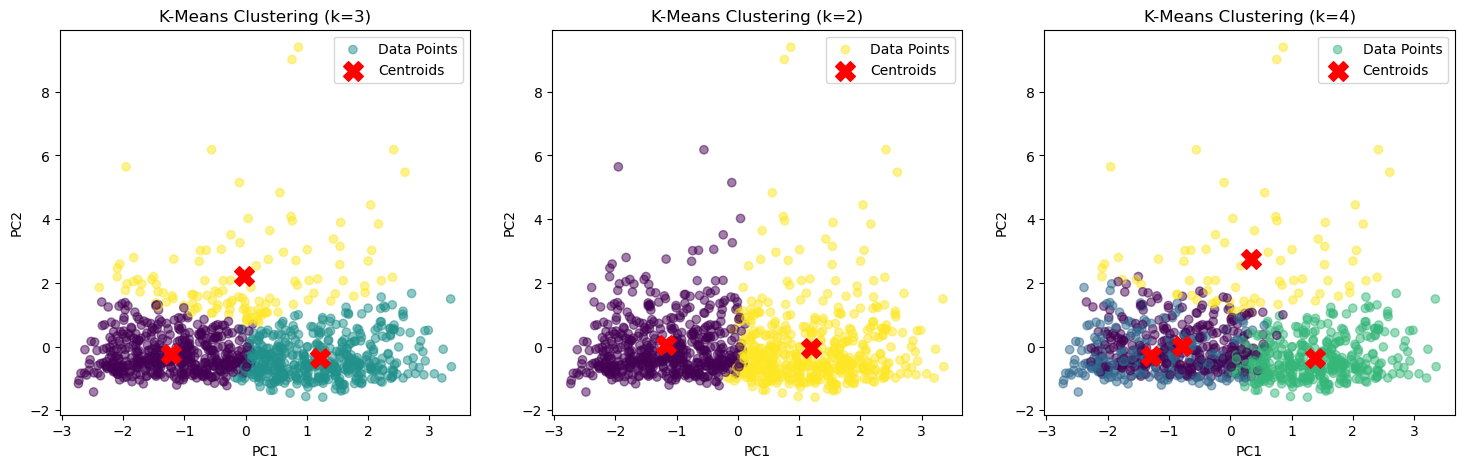

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, k in enumerate(best_k_values):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_kmeans = kmeans.fit_predict(df_pca)
    centroids = kmeans.cluster_centers_

    axes[i].scatter(df_pca["PC1"], df_pca["PC2"], c=labels_kmeans, cmap="viridis", alpha=0.5, label="Data Points")
    
    axes[i].scatter(centroids[:, 0], centroids[:, 1], c="red", marker="X", s=200, label="Centroids")
    
    axes[i].set_xlabel("PC1")
    axes[i].set_ylabel("PC2")
    axes[i].set_title(f"K-Means Clustering (k={k})")
    axes[i].legend()

plt.show()


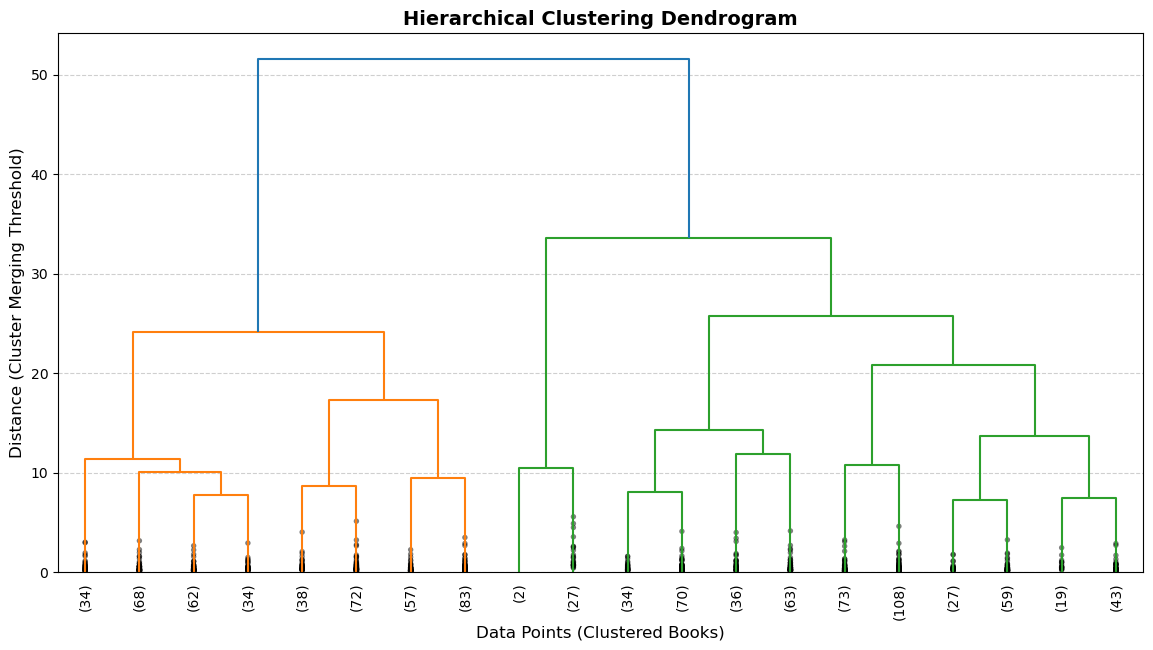

In [39]:
import scipy.cluster.hierarchy as sch

linkage_matrix = linkage(df_pca, method='ward')

plt.figure(figsize=(14, 7))
dendrogram(
    linkage_matrix,
    truncate_mode='lastp', 
    p=20,  
    leaf_rotation=90,  
    leaf_font_size=10, 
    show_contracted=True,  
    color_threshold=0.7 * max(linkage_matrix[:, 2])  
)

plt.title("Hierarchical Clustering Dendrogram", fontsize=14, fontweight='bold')
plt.xlabel("Data Points (Clustered Books)", fontsize=12)
plt.ylabel("Distance (Cluster Merging Threshold)", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

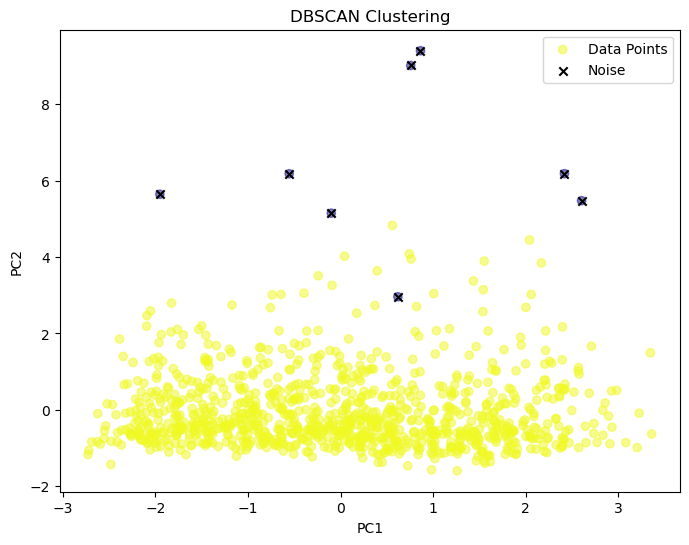

In [24]:
dbscan = DBSCAN(eps=1.5, min_samples=10)  
labels_dbscan = dbscan.fit_predict(df_pca)

plt.figure(figsize=(8, 6))
plt.scatter(df_pca["PC1"], df_pca["PC2"], c=labels_dbscan, cmap="plasma", alpha=0.5, label="Data Points")

noise_mask = labels_dbscan == -1
plt.scatter(df_pca["PC1"][noise_mask], df_pca["PC2"][noise_mask], c="black", label="Noise", marker="x")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("DBSCAN Clustering")
plt.legend()
plt.show()

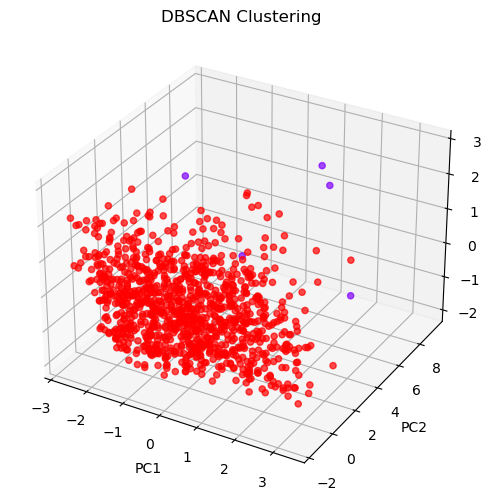

In [26]:
dbscan = DBSCAN(eps=1.5, min_samples=5)
df_pca["DBSCAN_Cluster"] = dbscan.fit_predict(df_pca)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df_pca["PC1"], df_pca["PC2"], df_pca["PC3"], c=df_pca["DBSCAN_Cluster"], cmap='rainbow', alpha=0.7)
ax.set_title("DBSCAN Clustering")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

plt.show()